In [29]:
import matplotlib.pyplot as plt
import numpy as np
import nltk
import pandas as pd
import plotly.express as px
import seaborn as sns
import os

In [30]:
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [31]:
hotels_test = pd.read_csv('sf-booking/hotels_test.csv')
hotels_train = pd.read_csv('sf-booking/hotels_train.csv')
sample_submission = pd.read_csv('sf-booking/submission.csv')

In [32]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
hotels_train['sample'] = 1 # помечаем где у нас трейн
hotels_test['sample'] = 0 # помечаем где у нас тест
hotels_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = hotels_test.append(hotels_train, sort=False).reset_index(drop=True) # объединяем

/var/folders/vb/zgs95gns137_hr2djgnk43wc0000gn/T/ipykernel_6417/2182963516.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hotels = hotels_test.append(hotels_train, sort=False).reset_index(drop=True) # объединяем


In [33]:
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0


# Data Understanding

In [34]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [35]:
sample_submission.head(3)

,reviewer_score,id
0,8.401,488440
1,7.378,274649
2,8.478,374688


# Feature Engineering and Filling In the Gaps

In [36]:
# Fill NA/NaN values using the specified method
cols_null_percent = hotels.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

lat    0.633655
lng    0.633655
dtype: float64

In [37]:
#Из признака "hotel_address" можно "вытащить" 2 новых признака - это признаки города и страны!
#Добавляем новый признак "Страны"

hotels['hotel_country'] = hotels['hotel_address'].apply(lambda x: x.split()[-1])
hotels.loc[hotels['hotel_country'] == 'Kingdom','hotel_country'] = 'United Kingdom'

#Добавляем новый признак "Города"

hotels['hotel_city'] = hotels['hotel_address'].apply(lambda x: x.split()[-5] if x.split()[-1] == 'Kingdom' else x.split()[-2])

In [38]:
#Заполняем пропуски в признаках 'lat' и 'lng'

values_lat = {
    'Milan': 45.4642700,
    'Amsterdam': 52.3740300,
    'Barcelona': 41.3887900,
    'London': 51.5085300,
    'Paris': 48.8534100,
    'Vienna': 48.2084900
}

values_lng = {
    'Milan': 9.1895100,
    'Amsterdam': 4.8896900,
    'Barcelona': 2.1589900,
    'London': -0.1257400,
    'Paris': 2.3488000,
    'Vienna': 16.3720800
}

hotels['lat'] = hotels[['hotel_city','lat']].apply(lambda x: values_lat[x.hotel_city] if np.isnan(x.lat) else x.lat, axis=1)
hotels['lng'] = hotels[['hotel_city','lng']].apply(lambda x: values_lng[x.hotel_city] if np.isnan(x.lng) else x.lng, axis=1)

In [39]:
#Проверяем наши данные на пропуски и видим, что пропусков больше нет!
hotels.isnull().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
reviewer_score                                0
hotel_country                                 0
hotel_city                                    0
dtype: int64

In [40]:
# Tasks 4.2
# how many unique hotels
hotels['hotel_name'].nunique()

1492

## Working with the column "review date"

In [41]:
# Tasks 4.3
hotels['review_date'] = pd.to_datetime(hotels['review_date'], format = '%m/%d/%Y')
display(hotels['review_date'])

0        2017-07-21
1        2016-12-12
2        2015-11-26
3        2015-10-17
4        2016-05-16
            ...    
515733   2017-04-19
515734   2017-02-13
515735   2016-02-07
515736   2017-05-21
515737   2016-08-05
Name: review_date, Length: 515738, dtype: datetime64[ns]

In [42]:
hotels['review_date'].agg(['min', 'max'])

min   2015-08-04
max   2017-08-03
Name: review_date, dtype: datetime64[ns]

## Working with the column "tags"

In [43]:
# Tasks 4.4
def re_func(num_tags):
    num_tags = num_tags[2:-2]
    res = num_tags.strip().split(' \', \' ')
    return res

hotels['tags'] = hotels['tags'].apply(re_func)

#hotels['tags_new'] = hotels['tags'].apply(re_func)
#n_tags = hotels.explode('tags_new')
#len(n_tags['tags_new'].unique())

# Answer: 2428

In [44]:
data_copy = hotels.explode('tags')
tags_counts = data_copy['tags'].value_counts()[:20]
data_tags_counts = pd.DataFrame(tags_counts).reset_index()
data_tags_counts.columns = ['unique_tags', 'counts_unique_tags']
top_tags = set(data_tags_counts['unique_tags'])

# Используем эти 20 тегов что бы создать в нашем датасете 20 новых признаков
# 1 -  в отзыве есть этот тег, 0 - тега нет

for tag in top_tags:
    tag_name = str(tag)
    hotels[tag_name] =  hotels['tags'].apply(lambda x: 1 if tag_name in x else 0)

In [45]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 40 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

In [46]:
# Remove columns with type 'object'
drop_hotels_data = hotels.copy()
hotels = drop_hotels_data.drop(
    ['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review','tags', 
     'days_since_review', 'hotel_city', 'hotel_country'], axis = 1)

hotels.head(3)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score,...,Classic Double Room,Stayed 3 nights,Stayed 1 night,Double or Twin Room,Leisure trip,Family with young children,Stayed 4 nights,Couple,Group,Submitted from a mobile device
0,904,8.1,52,16670,62,1,45.533137,9.171102,0,0.0,...,0,0,0,0,1,0,0,1,0,0
1,612,8.6,10,5018,0,7,52.385649,4.834443,0,0.0,...,0,0,1,0,1,0,0,0,1,0
2,46,8.3,3,351,5,15,41.393192,2.161520,0,0.0,...,0,0,1,0,0,0,0,0,0,1


In [21]:
# Tasks 4.5
# tags['tags_new'].value_counts()

In [ ]:
# Tasks 4.6
count_nights = 0
stayed_list = []
for tag in n_tags['tags_new']:
    if 'Stayed' in tag:
        stayed_list.append(tag)
        count_nights += 1
print(count_nights)
n_tags2 = pd.DataFrame({'night': stayed_list})
n_tags2['night'].value_counts()

NameError: name 'n_tags' is not defined

# Model 

In [47]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

In [48]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [49]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [52]:
# непрерывные признаки
num_cols = ['additional_number_of_scoring','review_total_negative_word_counts','total_number_of_reviews', 
            'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given']

# категориальные признаки
cat_cols = ['average_score', 'lat']

# Feature Selection

## Evaluation of categorigal parameters

<AxesSubplot: >

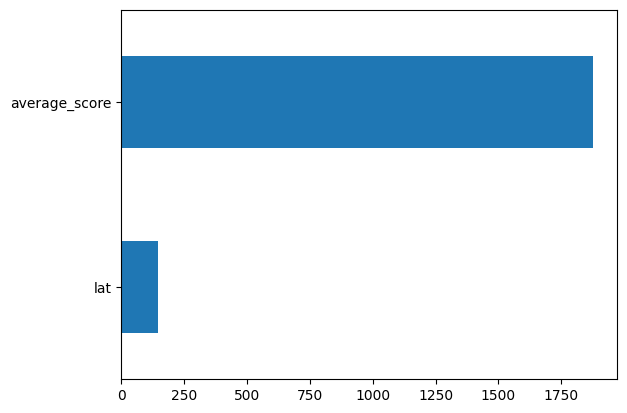

In [53]:
y = y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

## Evaluation of numerical parameters

<AxesSubplot: >

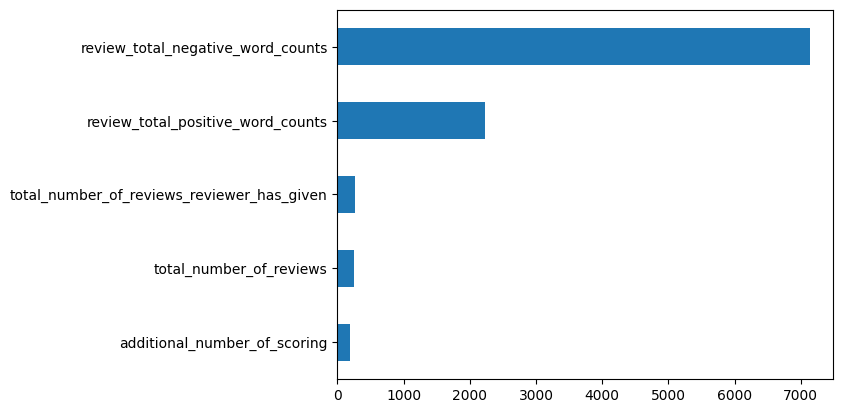

In [54]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [55]:
drop_cols = ['additional_number_of_scoring', 'total_number_of_reviews', 'lat', 'total_number_of_reviews_reviewer_has_given']

hotels.drop(drop_cols, axis = 1, inplace=True)

In [56]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [57]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.1021452252520783


Небольшой бонус:


In [ ]:
# # убираем признаки которые еще не успели обработать, 
# # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
# object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
# hotels.drop(object_columns, axis = 1, inplace=True)

# # заполняем пропуски самым простым способом
# hotels = hotels.fillna(0)